# Import Packages and Datasets

In [52]:
# Import packages
import scanpy as sc
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse
import pandas as pd
import seaborn as sns
from scipy.stats import pearsonr
import scanpy.external as sce
import random

In [39]:
# Import dataset
## ~ 33k Genes
# scRNA_ckd = sc.read_h5ad('/Volumes/CHAMPANERI/Databases/Human_Nor-CKD-AKF_scRNA.h5ad') # USB Location
scRNA_ckd_akf = sc.read_h5ad('/Users/aumchampaneri/Databases/Human_Nor-CKD-AKF_scRNA.h5ad') # Disk Location

# Filter Data for only Chronic Kidney Disease (CKD) Samples

In [40]:
# Subset the anndata object to only include Chronic Kidney Disease (CKD) samples
scRNA_ckd = scRNA_ckd_akf[scRNA_ckd_akf.obs['disease'] == 'chronic kidney disease', :].copy()

# # Subset the anndata object to only include Acute Kidney Failure (AKF) samples
# scRNA_akf = scRNA_ckd_akf[scRNA_ckd_akf.obs['disease'] == 'acute kidney failure', :].copy()

# Preprocess Data and Quality Control

In [14]:
# Preprocessing of the Data

# Basic filtering
# Filter out cells that express fewer than 500 genes to remove low-quality cells, empty droplets, and debris.
sc.pp.filter_cells(scRNA_ckd, min_genes=500, inplace=True)
# Filter out genes that are detected in fewer than 3 cells to eliminate technical noise and very rarely expressed genes.
sc.pp.filter_genes(scRNA_ckd, min_cells=3, inplace=True)

'''
Annotate the group of mitochondrial genes as 'mt'
Calculate QC metrics for further filtering

# scRNA_ckd.var["mt"] = scRNA_ckd.var_names.str.startswith("MT-")
# sc.pp.calculate_qc_metrics(scRNA_ckd, qc_vars=["mt"], percent_top=None, log1p=False, inplace=True)

Violin plots of QC metrics -- give us information about how to proceed with filtering
Show NO mitochondrial genes and no cells with high total counts -- No further filtering
Uncomment to see the plots

# sc.pl.violin(scRNA_ckd, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'], jitter=0.4, multi_panel=True)
# sc.pl.scatter(scRNA_ckd, x="total_counts", y="pct_counts_mt")
# sc.pl.scatter(scRNA_ckd, x="total_counts", y="n_genes_by_counts")
'''

# Normalize, log-transform, and scale the data
# Normalize the total gene expression in each cell to a target sum of 10,000 to correct for differences in sequencing depth.
sc.pp.normalize_total(scRNA_ckd, target_sum=1e4)
# Apply a natural logarithm transformation to the normalized data to stabilize variance and make expression values more comparable.
sc.pp.log1p(scRNA_ckd)

# Identify and plot highly-variable genes
# Identify highly-variable genes based on their mean expression and dispersion.
sc.pp.highly_variable_genes(scRNA_ckd, min_mean=0.0125, max_mean=3, min_disp=0.5)
# sc.pl.highly_variable_genes(scRNA_ckd)

# Store the raw data before further processing
scRNA_ckd.raw = scRNA_ckd.copy()

In [41]:
scRNA_ckd

AnnData object with n_obs × n_vars = 130630 × 31332
    obs: 'orig.ident', 'nCount_RNA', 'SpecimenID', 'LibraryID', 'SampleID', 'Run', 'clusterNumber', 'subclass.l1', 'dataSource', 'diseasetype', 'Race', 'clusterClass', 'organism_ontology_term_id', 'assay_ontology_term_id', 'sampletype', 'disease_ontology_term_id', 'sex_ontology_term_id', 'donor_id', 'suspension_type', 'tissue_ontology_term_id', 'tissue_type', 'self_reported_ethnicity_ontology_term_id', 'development_stage_ontology_term_id', 'Age_binned', 'cell_type_ontology_term_id', 'author_cell_type', 'diabetes_history', 'hypertension', 'eGFR', 'is_primary_data', 'disease_category', 'nFeature_RNA', 'percent.mt', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage', 'observation_joinid'
    var: 'index', 'feature_is_filtered', 'feature_name', 'feature_reference', 'feature_biotype', 'feature_length', 'feature_type'
    uns: 'batch_condition', 'citation', 'default_embedding', 'sche

In [17]:
scRNA_ckd

AnnData object with n_obs × n_vars = 130612 × 29039
    obs: 'orig.ident', 'nCount_RNA', 'SpecimenID', 'LibraryID', 'SampleID', 'Run', 'clusterNumber', 'subclass.l1', 'dataSource', 'diseasetype', 'Race', 'clusterClass', 'organism_ontology_term_id', 'assay_ontology_term_id', 'sampletype', 'disease_ontology_term_id', 'sex_ontology_term_id', 'donor_id', 'suspension_type', 'tissue_ontology_term_id', 'tissue_type', 'self_reported_ethnicity_ontology_term_id', 'development_stage_ontology_term_id', 'Age_binned', 'cell_type_ontology_term_id', 'author_cell_type', 'diabetes_history', 'hypertension', 'eGFR', 'is_primary_data', 'disease_category', 'nFeature_RNA', 'percent.mt', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage', 'observation_joinid', 'n_genes'
    var: 'index', 'feature_is_filtered', 'feature_name', 'feature_reference', 'feature_biotype', 'feature_length', 'feature_type', 'n_cells', 'highly_variable', 'means', 'dispersions', 

# Generate PCA and UMAP plus calculate Dendrogram Keys

2025-03-27 22:25:30,378 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2025-03-27 22:25:43,049 - harmonypy - INFO - sklearn.KMeans initialization complete.
2025-03-27 22:25:43,639 - harmonypy - INFO - Iteration 1 of 10
2025-03-27 22:26:36,948 - harmonypy - INFO - Iteration 2 of 10
2025-03-27 22:28:01,442 - harmonypy - INFO - Iteration 3 of 10
2025-03-27 22:29:12,308 - harmonypy - INFO - Iteration 4 of 10
2025-03-27 22:30:05,004 - harmonypy - INFO - Iteration 5 of 10
2025-03-27 22:30:44,179 - harmonypy - INFO - Iteration 6 of 10
2025-03-27 22:31:14,313 - harmonypy - INFO - Iteration 7 of 10
2025-03-27 22:31:44,838 - harmonypy - INFO - Iteration 8 of 10
2025-03-27 22:32:10,585 - harmonypy - INFO - Iteration 9 of 10
2025-03-27 22:32:38,304 - harmonypy - INFO - Iteration 10 of 10
2025-03-27 22:33:00,734 - harmonypy - INFO - Stopped before convergence


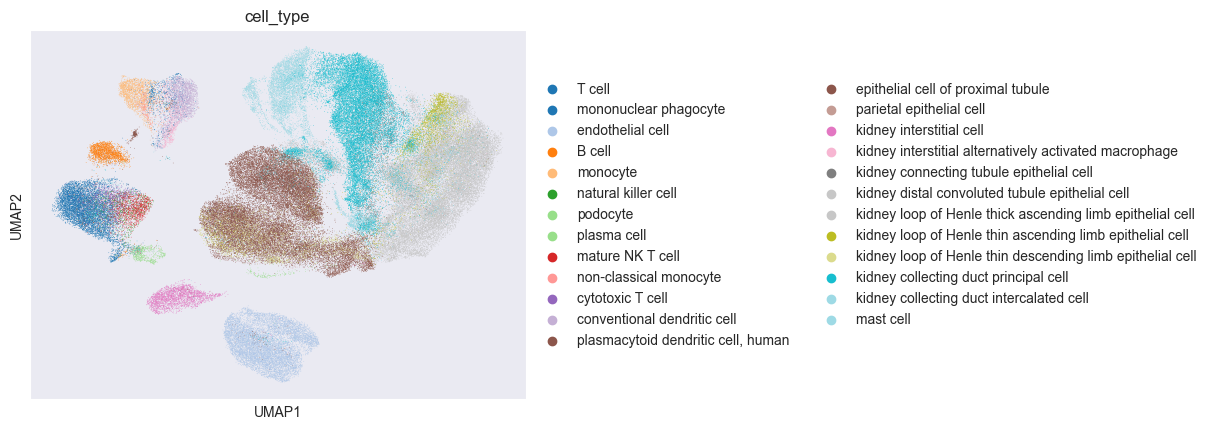

In [57]:
# Principal Component Analysis (PCA)
sc.pp.pca(scRNA_ckd, svd_solver="arpack")
# Plot the PCA -- Uncomment to see the plot
# sc.pl.pca(scRNA_ckd)
# sc.pl.pca_variance_ratio(scRNA_ckd, log=True)

# Generate UMAP
sce.pp.harmony_integrate(scRNA_ckd, "donor_id")
sc.pp.neighbors(scRNA_ckd, use_rep='X_pca_harmony', key_added='harmony')
sc.tl.umap(scRNA_ckd, neighbors_key='harmony')
sc.pl.umap(scRNA_ckd, color=['cell_type'])
#
# # Leiden clustering
# sc.tl.leiden(scRNA_ckd, flavor='igraph', n_iterations=2)
# sc.pl.umap(scRNA_ckd, color=['cell_type']) # Looks better with dark background
#
# # Dendrogram Key for downstream visualization
# sc.tl.dendrogram(scRNA_ckd, groupby='cell_type')

# Dictionaries

## Gene Dictionaries

In [46]:
# All Complement Genes
gene_dict = {
    'C1D': 'ENSG00000197223',
    'C1QA': 'ENSG00000173372',
    'C1QB': 'ENSG00000173369',
    'C1QC': 'ENSG00000159189',
    'C1QBP': 'ENSG00000108561',
    'C1R': 'ENSG00000159403',
    'C1RL': 'ENSG00000139178',
    'C1S': 'ENSG00000182326',
    'C2_ENSG00000166278': 'ENSG00000166278',
    'C3_ENSG00000125730': 'ENSG00000125730',
    'C3AR1': 'ENSG00000171860',
    'C4A': 'ENSG00000244731',
    'C4B': 'ENSG00000224389',
    'C4BPA': 'ENSG00000123838',
    'C4BPB': 'ENSG00000123843',
    'C5': 'ENSG00000106804',
    'C5AR1': 'ENSG00000197405',
    'C5AR2': 'ENSG00000134830',
    'C6_ENSG00000039537': 'ENSG00000039537',
    'C7_ENSG00000112936': 'ENSG00000112936',
    'C8A': 'ENSG00000157131',
    'C8B': 'ENSG00000021852',
    'C8G': 'ENSG00000176919',
    'C9_ENSG00000113600': 'ENSG00000113600',
    'CALR': 'ENSG00000179218',
    'CD46': 'ENSG00000117335',
    'CD55': 'ENSG00000196352',
    'CD59': 'ENSG00000085063',
    'CD93': 'ENSG00000125810',
    'CFB': 'ENSG00000243649',
    'CFD': 'ENSG00000197766',
    'CFH': 'ENSG00000000971',
    'CFHR1': 'ENSG00000244414',
    'CFHR2': 'ENSG00000080910',
    'CFHR3': 'ENSG00000116785',
    'CFHR4': 'ENSG00000134365',
    'CFHR5': 'ENSG00000134389',
    'CFI': 'ENSG00000205403',
    'CLU': 'ENSG00000120885',
    'COLEC10': 'ENSG00000184374',
    'COLEC11': 'ENSG00000118004',
    'CPB2': 'ENSG00000080618',
    'CPN1': 'ENSG00000120054',
    'CPN2': 'ENSG00000178772',
    'CSMD1': 'ENSG00000183117',
    'CFP': 'ENSG00000126759',
    'CR1': 'ENSG00000203710',
    'CR2': 'ENSG00000117322',
    'FCN1': 'ENSG00000085265',
    'FCN2': 'ENSG00000160339',
    'FCN3': 'ENSG00000142748',
    'ITGAM': 'ENSG00000169896',
    'ITGAMX': 'XXX',
    'ITGAX': 'ENSG00000140678',
    'ITGB2': 'ENSG00000160255',
    'MASP1': 'ENSG00000127241',
    'MASP2': 'ENSG00000009724',
    'MASP3': 'XXX',
    'MBL2': 'ENSG00000165471',
    'SERPING1': 'ENSG00000149131',
    'SUSD4': 'ENSG00000143502',
    'VSIG4': 'ENSG00000155659',
    'VCP': 'ENSG00000165280'
}

# Extract keys and values into separate lists
gene_dict_names = list(gene_dict.keys())
gene_dict_keys = list(gene_dict.values())

print("gene_names =", gene_dict_names)
print("gene_keys =", gene_dict_keys)


# Create filter gene object
def filter_genes(gene_dict_names, genes_to_remove):
    # Filter out genes that are in the genes_to_remove list
    filtered_genes = [gene for gene in gene_dict_names if gene not in genes_to_remove]
    return filtered_genes

# Example list of genes to remove
genes_to_remove = ['C1QA', 'C1QB', 'C1QC', 'C1QBP']

# Get the filtered gene list
filtered_gene_list = filter_genes(gene_dict, genes_to_remove)
print(filtered_gene_list)

gene_names = ['C1D', 'C1QA', 'C1QB', 'C1QC', 'C1QBP', 'C1R', 'C1RL', 'C1S', 'C2_ENSG00000166278', 'C3_ENSG00000125730', 'C3AR1', 'C4A', 'C4B', 'C4BPA', 'C4BPB', 'C5', 'C5AR1', 'C5AR2', 'C6_ENSG00000039537', 'C7_ENSG00000112936', 'C8A', 'C8B', 'C8G', 'C9_ENSG00000113600', 'CALR', 'CD46', 'CD55', 'CD59', 'CD93', 'CFB', 'CFD', 'CFH', 'CFHR1', 'CFHR2', 'CFHR3', 'CFHR4', 'CFHR5', 'CFI', 'CLU', 'COLEC10', 'COLEC11', 'CPB2', 'CPN1', 'CPN2', 'CSMD1', 'CFP', 'CR1', 'CR2', 'FCN1', 'FCN2', 'FCN3', 'ITGAM', 'ITGAMX', 'ITGAX', 'ITGB2', 'MASP1', 'MASP2', 'MASP3', 'MBL2', 'SERPING1', 'SUSD4', 'VSIG4', 'VCP']
gene_keys = ['ENSG00000197223', 'ENSG00000173372', 'ENSG00000173369', 'ENSG00000159189', 'ENSG00000108561', 'ENSG00000159403', 'ENSG00000139178', 'ENSG00000182326', 'ENSG00000166278', 'ENSG00000125730', 'ENSG00000171860', 'ENSG00000244731', 'ENSG00000224389', 'ENSG00000123838', 'ENSG00000123843', 'ENSG00000106804', 'ENSG00000197405', 'ENSG00000134830', 'ENSG00000039537', 'ENSG00000112936', 'ENSG0

## Cell Type Dictionaries

In [47]:
# List all the cell types in the dataset
cell_types = scRNA_ckd.obs['cell_type'].unique()
print("Cell Types:")
for cell_type in cell_types:
    print(f"  {cell_type}")

# Define the groups for cell types
cell_type_groups = {
    'Myeloid Cells': ['monocyte', 'non-classical monocyte', 'mononuclear phagocyte',
                      'conventional dendritic cell', 'plasmacytoid dendritic cell, human'],
    'Kidney Cells': ['kidney distal convoluted tubule epithelial cell', 'epithelial cell of proximal tubule',
                     'kidney connecting tubule epithelial cell', 'kidney loop of Henle thick ascending limb epithelial cell',
                     'kidney collecting duct intercalated cell', 'kidney collecting duct principal cell',
                     'kidney loop of Henle thin descending limb epithelial cell', 'kidney loop of Henle thin ascending limb epithelial cell',
                     'kidney interstitial cell', 'podocyte', 'parietal epithelial cell', 'kidney interstitial alternatively activated macrophage'],
    'Endothelial Cells': ['endothelial cell'],
    'Epithelial Cells': ['podocyte', 'parietal epithelial cell'],
    'Immune Cells': ['T cell', 'cytotoxic T cell', 'natural killer cell', 'mature NK T cell',
                     'B cell', 'mast cell', 'plasma cell'],
}

# Map cell types to groups
scRNA_ckd.obs['cell_type_group'] = 'Other'
for group, cell_types in cell_type_groups.items():
    scRNA_ckd.obs.loc[scRNA_ckd.obs['cell_type'].isin(cell_types), 'cell_type_group'] = group

# Check the new amount of cell types
cell_type_groups = scRNA_ckd.obs['cell_type_group'].unique()
print("Cell Type Groups:")
for group in cell_type_groups:
    print(f"  {group}")

Cell Types:
  kidney loop of Henle thick ascending limb epithelial cell
  T cell
  kidney collecting duct principal cell
  epithelial cell of proximal tubule
  kidney connecting tubule epithelial cell
  cytotoxic T cell
  endothelial cell
  kidney collecting duct intercalated cell
  conventional dendritic cell
  kidney distal convoluted tubule epithelial cell
  natural killer cell
  kidney loop of Henle thin ascending limb epithelial cell
  mature NK T cell
  mononuclear phagocyte
  plasma cell
  kidney interstitial cell
  monocyte
  podocyte
  kidney interstitial alternatively activated macrophage
  parietal epithelial cell
  B cell
  mast cell
  non-classical monocyte
  plasmacytoid dendritic cell, human
  kidney loop of Henle thin descending limb epithelial cell
Cell Type Groups:
  Kidney Cells
  Immune Cells
  Endothelial Cells
  Myeloid Cells
  Epithelial Cells


# Plotting the Data

## UMAP

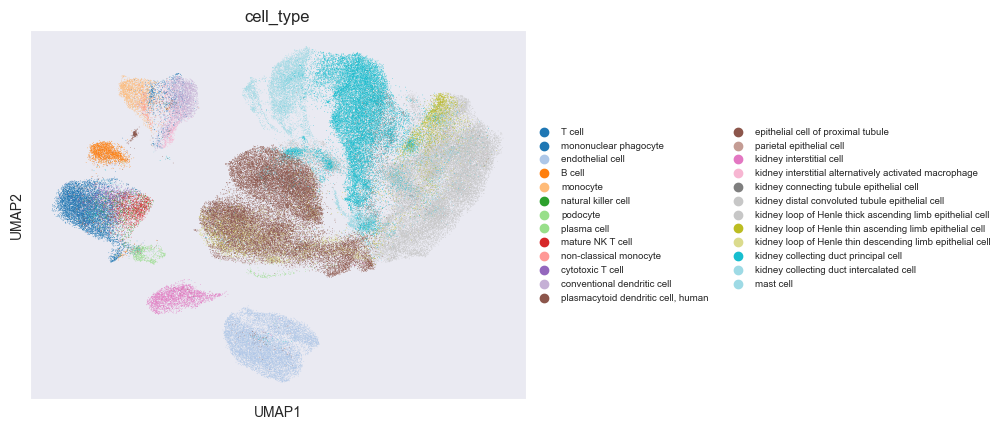

In [71]:
sc.pl.umap(scRNA_ckd,
           color=['cell_type'],
           legend_fontsize='x-small',
           legend_fontweight='light',
           # palette='custom_palette',
           # save='_cell-type_NKD.pdf',
           neighbors_key='harmony'
           )

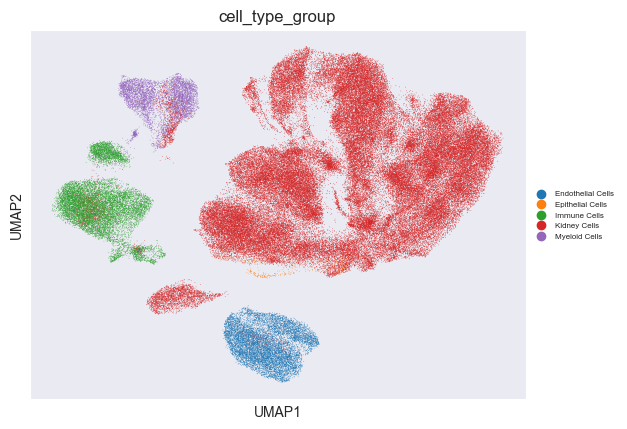

In [65]:
sc.pl.umap(scRNA_ckd,
           color=['cell_type_group'],
           legend_fontsize='xx-small',
           legend_fontweight='light',
           # palette='tab10',
           # save='_cell-type-group_CKD.pdf'
           )

## C3 and CFH UMAP

/var/folders/dk/j41qmgy16b5_49s_wh137t_m0000gn/T/ipykernel_14270/3691944288.py:113: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


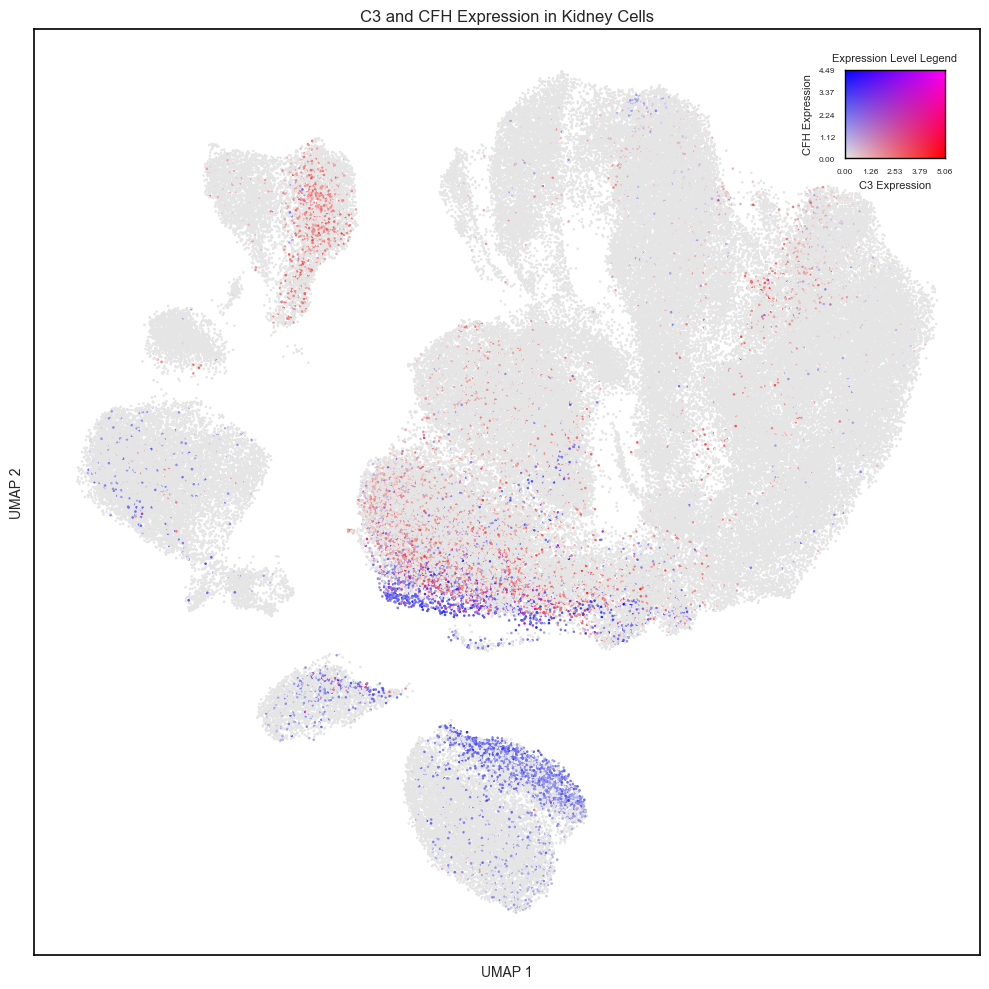

In [63]:
# Define gene keys for C3 and CFH
c3_key = "ENSG00000125730"  # C3
cfh_key = "ENSG00000000971"  # CFH


def get_expression(key):
    exp = scRNA_ckd[:, key].X
    return exp.toarray().flatten() if scipy.sparse.issparse(exp) else exp.flatten()


# Extract expression data
c3_vals = get_expression(c3_key)
cfh_vals = get_expression(cfh_key)

# Determine the data range for each gene
c3_min, c3_max = c3_vals.min(), c3_vals.max()
cfh_min, cfh_max = cfh_vals.min(), cfh_vals.max()

# Generate five evenly spaced tick values
c3_ticks = np.linspace(c3_min, c3_max, 5)
cfh_ticks = np.linspace(cfh_min, cfh_max, 5)

# Rescale the raw data to [0,1] for color mapping
X_scatter = (c3_vals - c3_min) / (c3_max - c3_min)
Y_scatter = (cfh_vals - cfh_min) / (cfh_max - cfh_min)

# Define the white basis as light grey
white_val = 0.9

# Compute weight factors
w = (1 - X_scatter) * (1 - Y_scatter)
r = X_scatter * (1 - Y_scatter)
b = (1 - X_scatter) * Y_scatter
p = X_scatter * Y_scatter

# Compute scatter plot colors
scatter_R = white_val * w + 1 * r + 0 * b + 1 * p
scatter_G = white_val * w + 0 * r + 0 * b + 0 * p
scatter_B = white_val * w + 0 * r + 1 * b + 1 * p

scatter_colors = np.column_stack([scatter_R, scatter_G, scatter_B])
scatter_colors = np.clip(scatter_colors, 0, 1)

# Create figure and axes
fig = plt.figure(figsize=(10, 10), facecolor='white')
ax_umap = fig.add_subplot(111)
ax_legend = fig.add_axes([0.85, 0.83, 0.10, 0.10])
ax_umap.set_facecolor('white')

# Plot UMAP scatter
ax_umap.scatter(
    scRNA_ckd.obsm['X_umap'][:, 0],
    scRNA_ckd.obsm['X_umap'][:, 1],
    c=scatter_colors,
    s=0.75,
    alpha=1.0
)

ax_umap.set_title('C3 and CFH Expression in Kidney Cells')
ax_umap.set_xlabel('UMAP 1')
ax_umap.set_ylabel('UMAP 2')
ax_umap.grid(False)
ax_umap.tick_params(axis='both', which='both', length=0)
ax_umap.set_xticklabels([])
ax_umap.set_yticklabels([])

for spine in ax_umap.spines.values():
    spine.set_visible(True)
    spine.set_color('black')
    spine.set_linewidth(1.2)

# ---- Build the legend colormap ----
n_bins = 100
x_lin = np.linspace(c3_min, c3_max, n_bins)
y_lin = np.linspace(cfh_min, cfh_max, n_bins)
X_leg, Y_leg = np.meshgrid(x_lin, y_lin)

# Rescale legend meshgrid values to [0,1]
X_leg_scaled = (X_leg - c3_min) / (c3_max - c3_min)
Y_leg_scaled = (Y_leg - cfh_min) / (cfh_max - cfh_min)

# Compute weight factors for the legend
w_leg = (1 - X_leg_scaled) * (1 - Y_leg_scaled)
r_leg = X_leg_scaled * (1 - Y_leg_scaled)
b_leg = (1 - X_leg_scaled) * Y_leg_scaled
p_leg = X_leg_scaled * Y_leg_scaled

# Compute legend color mapping
legend_R = white_val * w_leg + 1 * r_leg + 0 * b_leg + 1 * p_leg
legend_G = white_val * w_leg + 0 * r_leg + 0 * b_leg + 0 * p_leg
legend_B = white_val * w_leg + 0 * r_leg + 1 * b_leg + 1 * p_leg

legend_color = np.stack([legend_R, legend_G, legend_B], axis=2)
legend_color = np.clip(legend_color, 0, 1)

ax_legend.imshow(legend_color, origin='lower', extent=[c3_min, c3_max, cfh_min, cfh_max])
ax_legend.set_xlabel('C3 Expression', fontsize=8)
ax_legend.set_ylabel('CFH Expression', fontsize=8)
ax_legend.set_title('Expression Level Legend', fontsize=8)
ax_legend.grid(False)

# Apply the new tick values
ax_legend.set_xticks(c3_ticks)
ax_legend.set_yticks(cfh_ticks)
ax_legend.set_xticklabels([f"{val:.2f}" for val in c3_ticks], fontsize=6)
ax_legend.set_yticklabels([f"{val:.2f}" for val in cfh_ticks], fontsize=6)

for spine in ax_legend.spines.values():
    spine.set_visible(True)
    spine.set_color('black')
    spine.set_linewidth(1)

plt.tight_layout()
# plt.savefig('umap_C3vCFH_CKD.pdf')
plt.show()

# Scatter Plots

Category counts:
category
Neither       119424
C3 only         6357
CFH only        3863
C3 and CFH       986
Name: count, dtype: int64
Pearson correlation (C3 vs CFH): R=0.108, p=0.000e+00


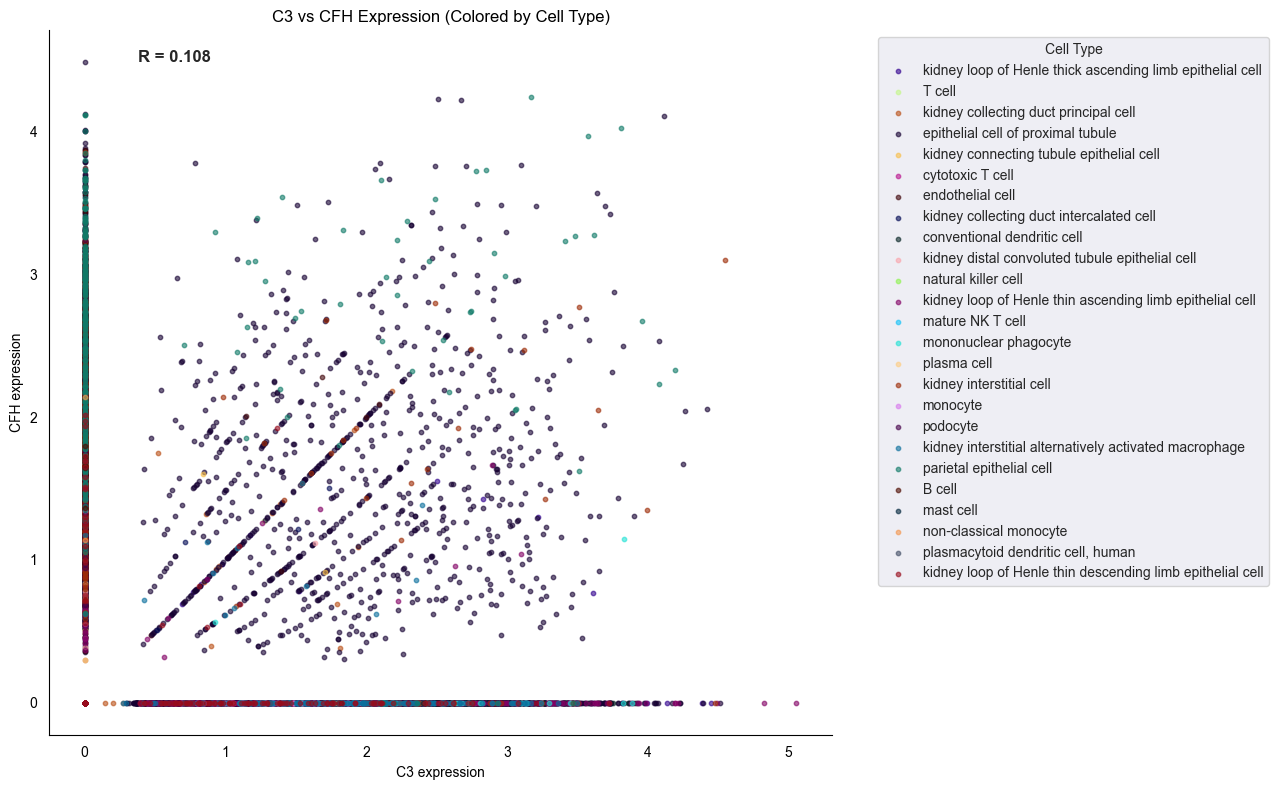

In [78]:
# Function to extract expression data
def get_expression(key):
    """
    Extracts expression data for a given gene key.

    Parameters:
    key (str): Gene key to extract expression data for.

    Returns:
    np.ndarray: Flattened array of expression data.
    """
    exp = scRNA_ckd[:, key].X
    return exp.toarray().flatten() if scipy.sparse.issparse(exp) else exp.flatten()


# Get the ENSEMBL IDs for C3 and CFH from the gene dictionary
c3_id = gene_dict["C3_ENSG00000125730"]  # "ENSG00000125730"
cfh_id = gene_dict["CFH"]  # "ENSG00000000971"

# Extract expression data for C3 and CFH
c3_expr = get_expression(c3_id)
cfh_expr = get_expression(cfh_id)

# Create DataFrame with expression values and cell type data
df = pd.DataFrame({
    "C3": c3_expr,
    "CFH": cfh_expr,
    "cell_type": scRNA_ckd.obs["cell_type"].values,
    "cell_type_group": scRNA_ckd.obs["cell_type_group"].values
})

# Define categories based on expression > 0
conditions = [
    (df["C3"] > 0) & (df["CFH"] > 0),
    (df["C3"] > 0) & (df["CFH"] == 0),
    (df["C3"] == 0) & (df["CFH"] > 0),
    (df["C3"] == 0) & (df["CFH"] == 0),
]
choices = ["C3 and CFH", "C3 only", "CFH only", "Neither"]
df["category"] = np.select(conditions, choices, default="Other")

# Print category counts
print("Category counts:")
print(df["category"].value_counts())

# Compute Pearson correlation
r, p_value = pearsonr(df["C3"], df["CFH"])
print(f"Pearson correlation (C3 vs CFH): R={r:.3f}, p={p_value:.3e}")

###############################################################################
# Scatter plot: Color points by cell type with improved aesthetics
###############################################################################

# Define unique cell types and their colors
cell_types = df["cell_type"].unique()
# palette = sns.color_palette("husl", n_colors=len(cell_types))
custom_palette = [
    "#020918", "#424e66", "#ffc61a", "#a2b20a", "#459201",
    "#4d0a00", "#9d2c07", "#ea7d10", "#f8be49", "#c3f787", "#47d163", "#107a68", "#01253c",
    "#082525", "#03683e", "#21b039", "#8df34f", "#99e7f4", "#12c2f8", "#0341b5", "#020a55",
    "#030d30", "#0b6f9d", "#22e2d5", "#d878ed", "#9232ec", "#30008f", "#160132", "#46024b",
    "#830165", "#b9138d", "#e057c9", "#faa3ab", "#ef5d7f", "#ee113d", "#980b1c", "#3f0409",
    "#190400", "#ba5017", "#f4964e", "#fecc81"
]
random.shuffle(custom_palette)
palette = sns.color_palette(custom_palette, n_colors=len(cell_types))
cell_type_colors = dict(zip(cell_types, palette))

# Create scatter plot
fig, ax = plt.subplots(figsize=(13, 8))

# Plot each cell type with its corresponding color
[
    ax.scatter(
        df[df["cell_type"] == cell_type]["C3"],
        df[df["cell_type"] == cell_type]["CFH"],
        s=10,
        alpha=0.6,
        color=cell_type_colors[cell_type],
        label=cell_type
    )
    for cell_type in cell_types
]

# Add Pearson correlation coefficient (R) at the top of the plot
ax.text(
    df["C3"].max() * 0.075,  # X position
    df["CFH"].max() * 1.00,  # Y position
    f"R = {r:.3f}",
    fontsize=12,
    fontweight="bold"
)

# Set axis properties
ax.spines["bottom"].set_color("black")
ax.spines["left"].set_color("black")
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.tick_params(axis="x", colors="black", direction="out", length=5, width=1.5)
ax.tick_params(axis="y", colors="black", direction="out", length=5, width=1.5)
ax.set_facecolor("white")
fig.patch.set_facecolor("white")
ax.grid(False)

# Labels and title
ax.set_xlabel("C3 expression", color="black")
ax.set_ylabel("CFH expression", color="black")
ax.set_title("C3 vs CFH Expression (Colored by Cell Type)", color="black")

# Move legend outside the plot to the right
ax.legend(title="Cell Type", bbox_to_anchor=(1.05, 1), loc="upper left", frameon=True, fontsize=10)

plt.tight_layout()
# plt.savefig('scatterplot_C3vCFH-cell-type_CKD.pdf')
plt.show()

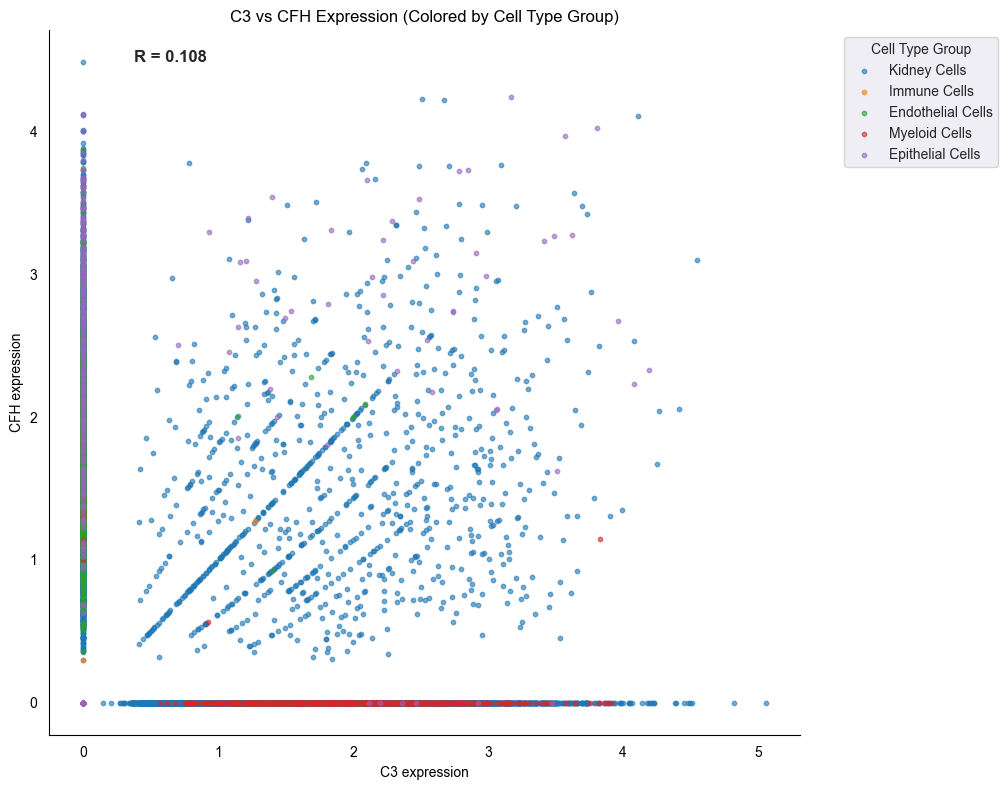

In [75]:
# Define unique cell type groups and their colors
cell_type_groups = df["cell_type_group"].unique()
palette = sns.color_palette("tab10", n_colors=len(cell_type_groups))
cell_type_group_colors = dict(zip(cell_type_groups, palette))

# Create scatter plot
fig, ax = plt.subplots(figsize=(10.2, 8))

# Plot each cell type group with its corresponding color
for cell_type_group in cell_type_groups:
    subset = df[df["cell_type_group"] == cell_type_group]
    ax.scatter(
        subset["C3"],
        subset["CFH"],
        s=10,
        alpha=0.6,
        color=cell_type_group_colors[cell_type_group],
        label=cell_type_group
    )

# Add Pearson correlation coefficient (R) at the top of the plot
ax.text(
    df["C3"].max() * 0.075,  # X position
    df["CFH"].max() * 1.00,  # Y position
    f"R = {r:.3f}",
    fontsize=12,
    fontweight="bold"
)

# Set axis properties
ax.spines["bottom"].set_color("black")
ax.spines["left"].set_color("black")
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.tick_params(axis="x", colors="black", direction="out", length=5, width=1.5)
ax.tick_params(axis="y", colors="black", direction="out", length=5, width=1.5)
ax.set_facecolor("white")
fig.patch.set_facecolor("white")
ax.grid(False)

# Labels and title
ax.set_xlabel("C3 expression", color="black")
ax.set_ylabel("CFH expression", color="black")
ax.set_title("C3 vs CFH Expression (Colored by Cell Type Group)", color="black")

# Move legend outside the plot to the right
ax.legend(title="Cell Type Group", bbox_to_anchor=(1.05, 1), loc="upper left", frameon=True, fontsize=10)

plt.tight_layout()
# plt.savefig('scatterplot_C3vCFH-cell-group_CKD.pdf')
plt.show()

## Matrix Plots

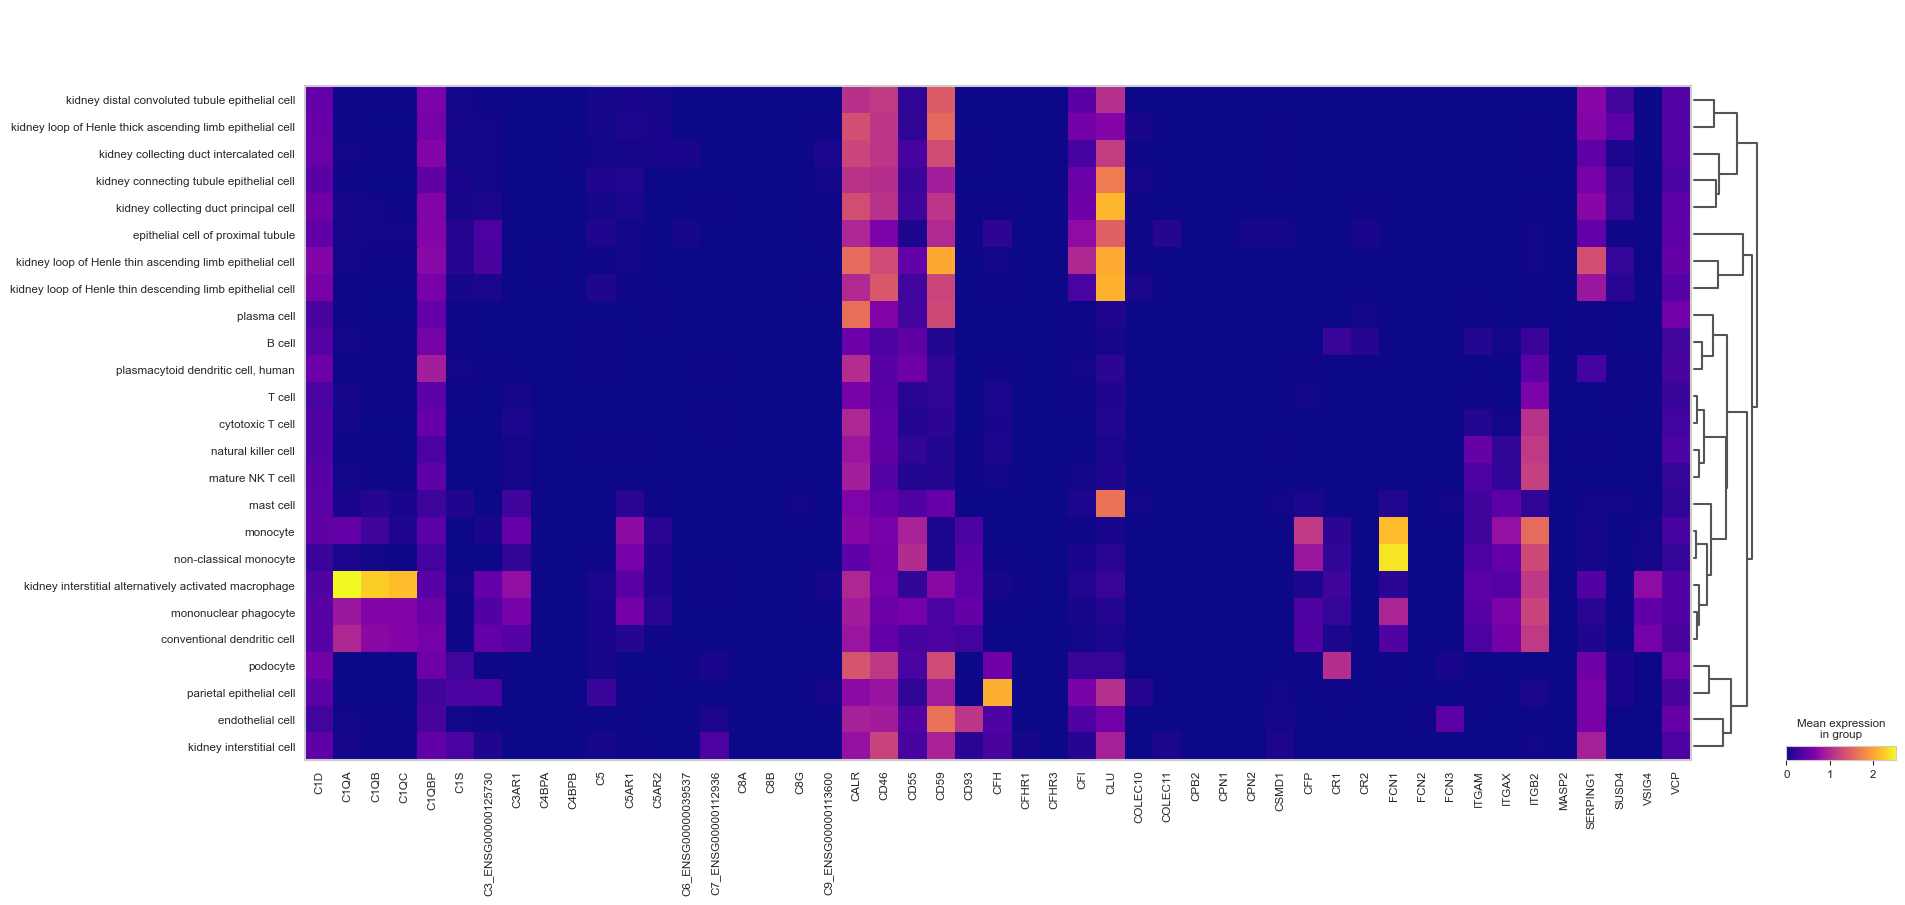

In [13]:
# Define the gene set for plotting
# List of genes to remove
genes_to_remove = ['C1R', 'C1RL', 'C2_ENSG00000166278', 'C4A', 'C4B', 'CFB', 'CFD', 'CFHR2', 'CFHR4', 'CFHR5', 'ITGAMX', 'MASP1', 'MASP3', 'MBL2']
# Get the filtered gene list
filtered_gene_list = filter_genes(gene_dict_names, genes_to_remove)

# Plot the expression of complement genes as a matrix plot
sc.pl.MatrixPlot(scRNA_ckd,
                 filtered_gene_list,
                 groupby='cell_type',
                 gene_symbols='feature_name',
                 use_raw=False,
                 log=False,
                 # title='Complement Genes Expression in Kidney Cells',
                 ).add_dendrogram(show=True, size=0.9).style(cmap='plasma', edge_color='none').show()
# .savefig('matrixplot_aG-aC_CKD.pdf')

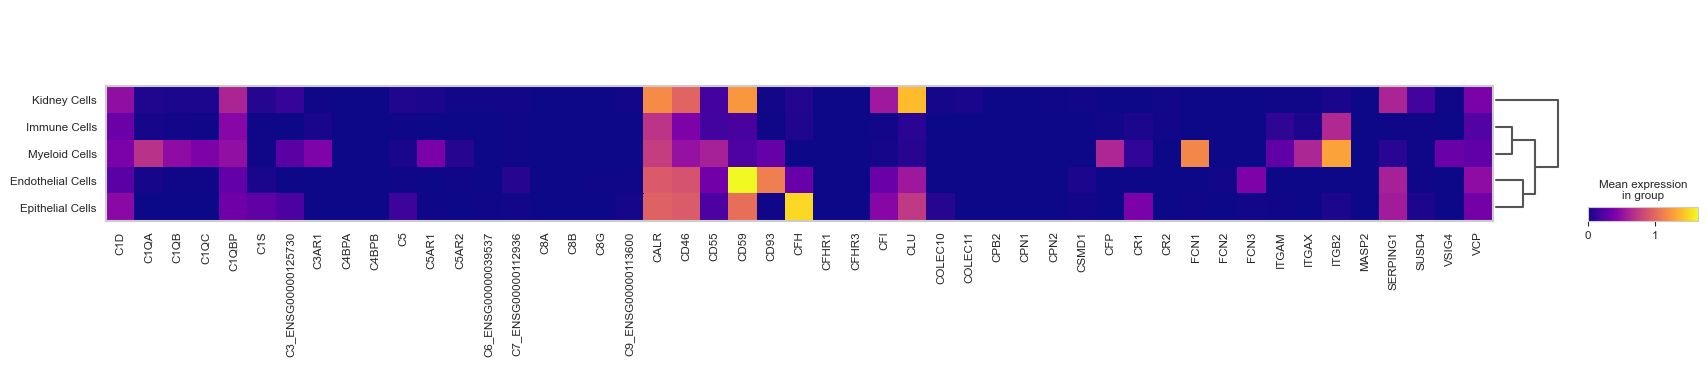

In [14]:
# Example list of genes to remove
genes_to_remove = ['C1R', 'C1RL', 'C2_ENSG00000166278', 'C4A', 'C4B', 'CFB', 'CFD', 'CFHR2', 'CFHR4', 'CFHR5', 'ITGAMX', 'MASP1', 'MASP3', 'MBL2']
# Get the filtered gene list
filtered_gene_list = filter_genes(gene_dict_names, genes_to_remove)

# Plot the expression of complement genes as a matrix plot only for cell_type_groups
sc.pl.MatrixPlot(scRNA_ckd,
                 filtered_gene_list,
                 groupby='cell_type_group',
                 gene_symbols='feature_name',
                 use_raw=False,
                 log=False,
                 # title='Complement Genes Expression in Kidney Cells',
                 ).add_dendrogram(show=True, size=0.9).style(cmap='plasma', edge_color='none').show()
 # .savefig('matrixplot_aG-sC_CKD.pdf')

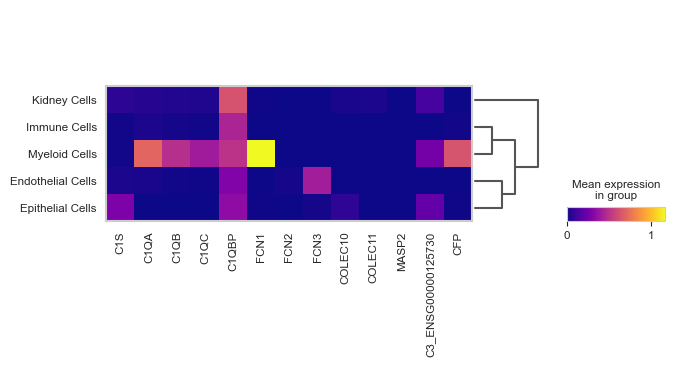

In [15]:
# Define the gene set for plotting
entry_pathway_comp = ['C1S','C1QA','C1QB','C1QC','C1QBP','FCN1','FCN2','FCN3','COLEC10','COLEC11','MASP2','C3_ENSG00000125730','CFP']

# Plot the expression of complement genes as a matrix plot only for cell_type_groups
sc.pl.MatrixPlot(scRNA_ckd,
                 entry_pathway_comp,
                 groupby='cell_type_group',
                 gene_symbols='feature_name',
                 use_raw=False,
                 log=False,
                 # title='Classical Pathway Components',
                 ).add_dendrogram(show=True, size=0.9).style(cmap='plasma', edge_color='none').show()
# .savefig('matrixplot_sG-sC_CKD.pdf')

## Dot Plots

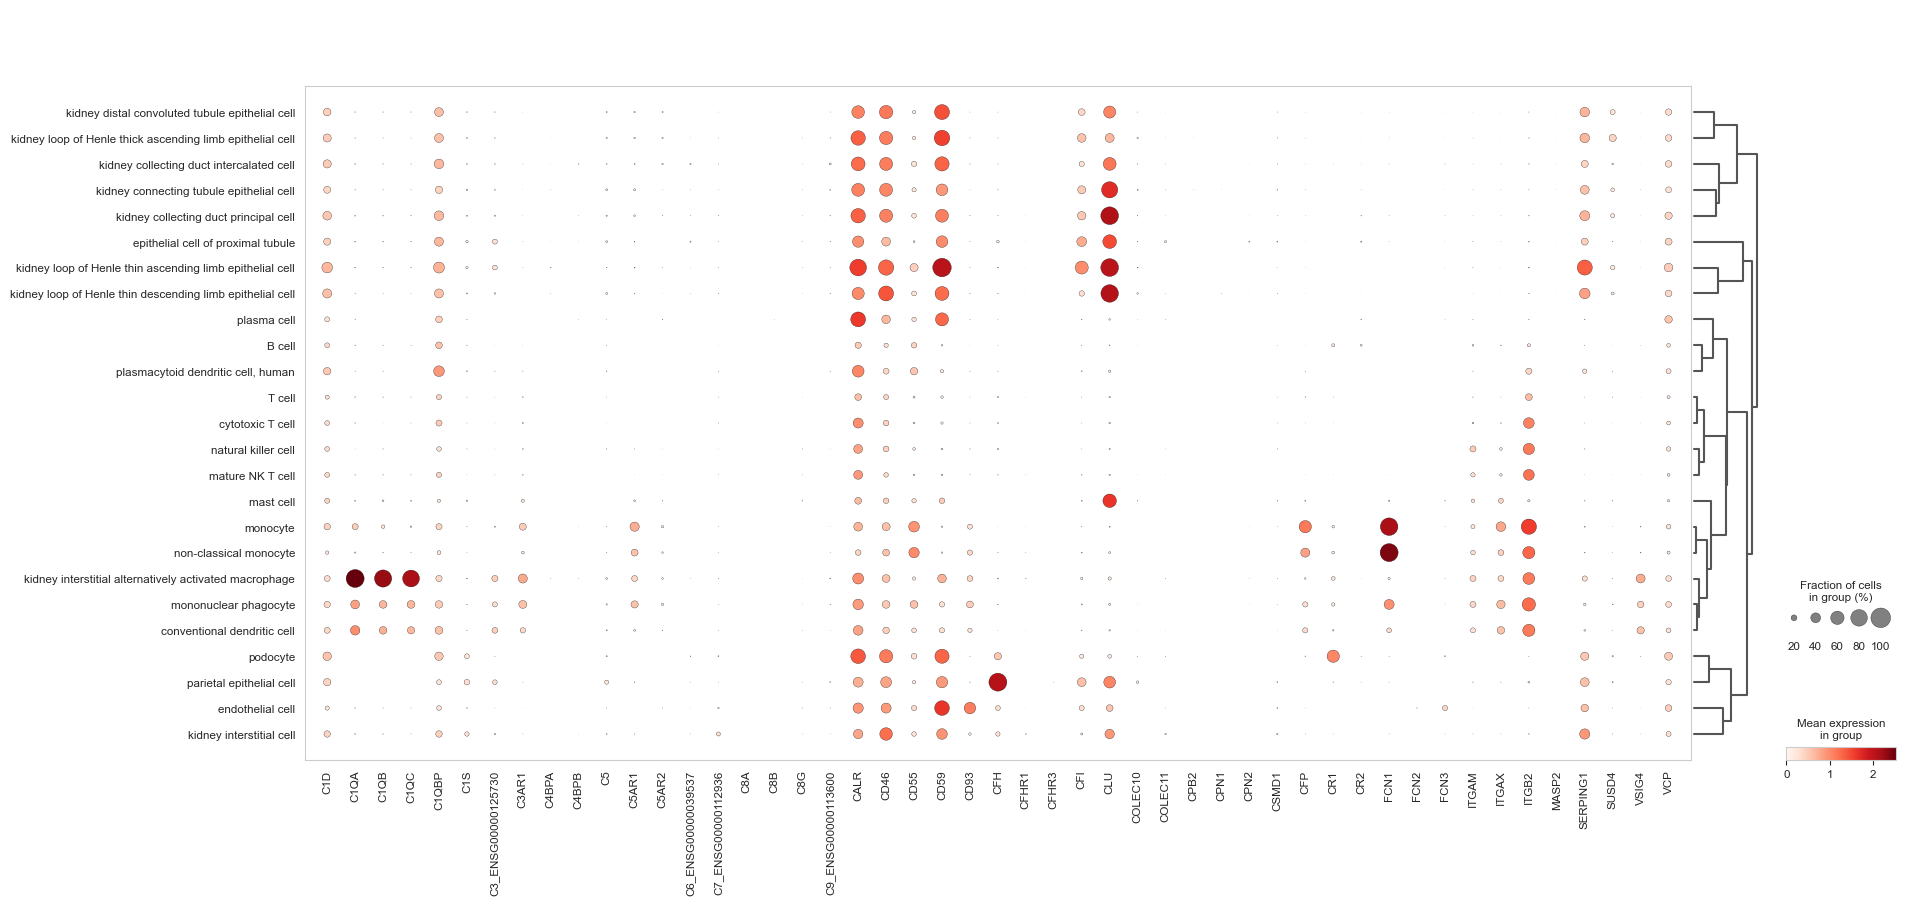

In [16]:
# Example list of genes to remove
genes_to_remove = ['C1R', 'C1RL', 'C2_ENSG00000166278', 'C4A', 'C4B', 'CFB', 'CFD', 'CFHR2', 'CFHR4', 'CFHR5', 'ITGAMX', 'MASP1', 'MASP3', 'MBL2']
# Get the filtered gene list
filtered_gene_list = filter_genes(gene_dict_names, genes_to_remove)

# Plot the expression of complement PRMs as a dot plot
sc.pl.DotPlot(scRNA_ckd,
              filtered_gene_list,
              groupby='cell_type',
              gene_symbols='feature_name',
              use_raw=False,
              log=False,
              ).add_dendrogram(show=True,size=0.9).show()
# .savefig('dotplot_aG-aC_CKD.pdf')

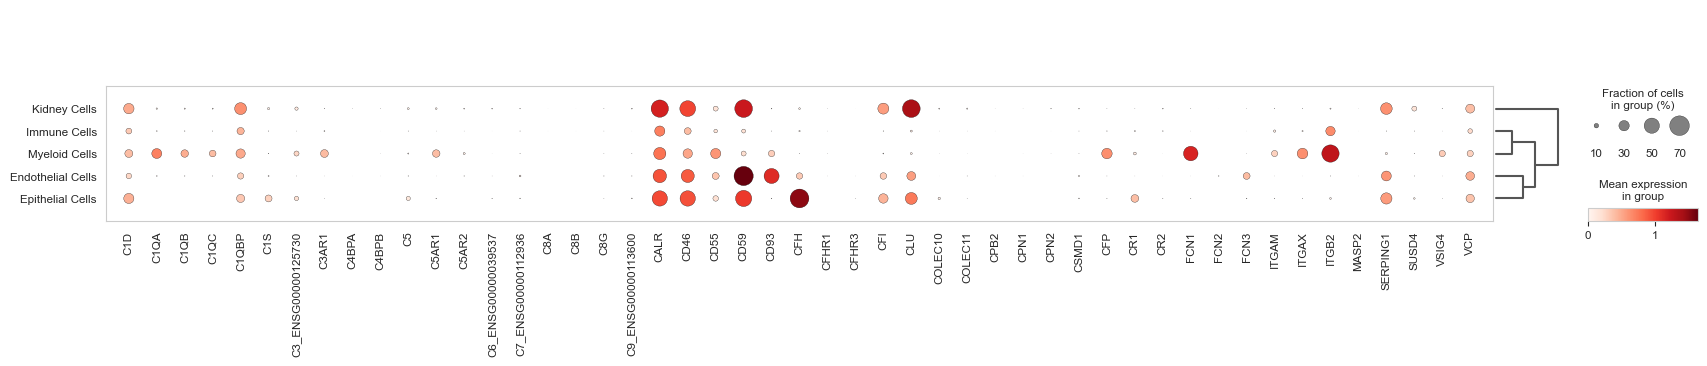

In [17]:
# Example list of genes to remove
genes_to_remove = ['C1R', 'C1RL', 'C2_ENSG00000166278', 'C4A', 'C4B', 'CFB', 'CFD', 'CFHR2', 'CFHR4', 'CFHR5', 'ITGAMX', 'MASP1', 'MASP3', 'MBL2']
# Get the filtered gene list
filtered_gene_list = filter_genes(gene_dict_names, genes_to_remove)

# Plot the expression of complement PRMs as a dot plot
sc.pl.DotPlot(scRNA_ckd,
              filtered_gene_list,
              groupby='cell_type_group',
              gene_symbols='feature_name',
              use_raw=False,
              log=False,
              ).add_dendrogram(show=True,size=0.9).show()
# .savefig('dotplot_aG-sC_CKD.pdf')

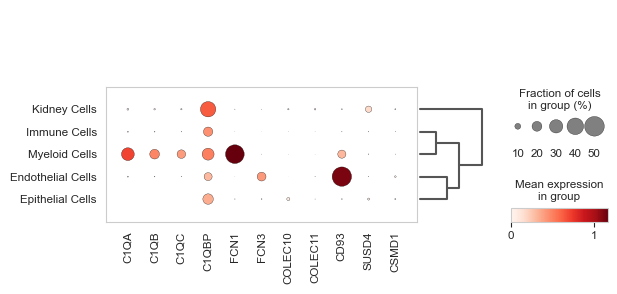

In [18]:
# Define the gene set for plotting
complement_prms = ['C1QA', 'C1QB', 'C1QC', 'C1QBP', 'FCN1', 'FCN3', 'COLEC10', 'COLEC11', 'CD93', 'SUSD4', 'CSMD1']

# Plot the expression of complement PRMs as a dot plot
sc.pl.DotPlot(scRNA_ckd,
              complement_prms,
              groupby='cell_type_group',
              gene_symbols='feature_name'
              ).add_dendrogram(show=True,size=0.9).show()
# .savefig('dotplot_aG-aC_CKD.pdf')